In [29]:
import numpy as np 
import pandas as pd 
import os

In [22]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sb
import torch 
from torchvision import models
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
import shutil
import os
import warnings
warnings.filterwarnings("ignore")

code_dir = "/kaggle/working/code"
model_dir = "/kaggle/working/model"
output_dir = "/kaggle/working/output"

if not os.path.exists(code_dir):
    os.mkdir(code_dir)

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
shutil.copyfile(src="/kaggle/input/modelos/convnext.py", 
                dst="/kaggle/working/code/convnext.py")
shutil.copyfile(src="/kaggle/input/modelos/convnext_tiny_1k_224_ema.pth", 
                dst="/kaggle/working/model/convnext_tiny_1k_224_ema.pth")
shutil.copyfile(src="/kaggle/input/modelos/vit_b_16-c867db91.pth", 
                dst="/kaggle/working/model/vit_b_16-c867db91.pth")

os.chdir("/kaggle/working/code")


from convnext import ConvNeXt


### Loading the data

In [23]:
files_directory = '/kaggle/input/140k-real-and-fake-faces'
train = pd.read_csv(files_directory + "/train.csv")
test = pd.read_csv(files_directory + "/test.csv")
print(test.shape)
print(train.shape)

(20000, 6)
(100000, 6)


## Dataframe

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [27]:
train_acc, teste_acc, train_loss, teste_loss = [], [], [], []
train_precision, teste_precision, train_recall, teste_recall = [], [], [], []
train_f1, teste_f1 = [], []
df = pd.DataFrame(columns=['Modelo','Experimento','Epoch', 'Train ACC', 'Train Loss', 'Train F1', 'Test ACC', 'Test Loss', 'Test F1'])

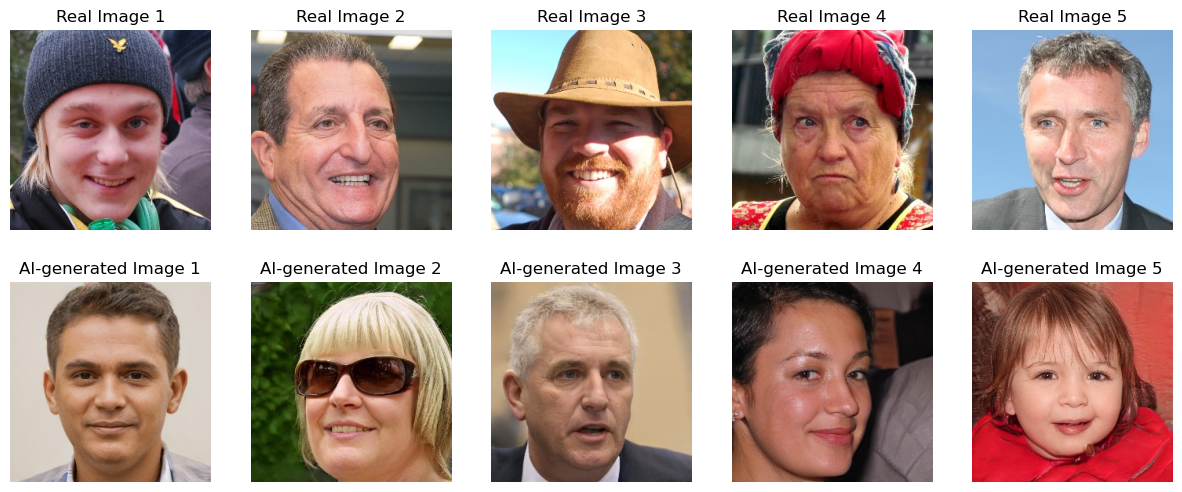

In [28]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
real_images_directory = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real'
ai_images_directory = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake'

num_images = 5
real_images_list = os.listdir(real_images_directory)[:num_images]
ai_images_list = os.listdir(ai_images_directory)[:num_images]
plt.figure(figsize=(15, 6))
for i, image in enumerate(real_images_list):
    plt.subplot(2, num_images, i + 1)
    img = mpimg.imread(os.path.join(real_images_directory, image))
    plt.imshow(img)
    plt.title(f'Real Image {i+1}')
    plt.axis('off')

for i, image in enumerate(ai_images_list):
    plt.subplot(2, num_images, num_images + i + 1)
    img = mpimg.imread(os.path.join(ai_images_directory, image))
    plt.imshow(img)
    plt.title(f'AI-generated Image {i+1}')
    plt.axis('off')

plt.show()


### Data Transformation


In [29]:
def full_data_transform( data_fraction, batch_size):

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
            
            
    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    full_train_dataset = ImageFolder(local_arquivos + "/train", transform=transform)
    full_test_dataset = ImageFolder(local_arquivos + "/test", transform=transform)
            
    num_train_data = int(len(full_train_dataset) * data_fraction)
    num_test_data = int(len(full_test_dataset) * data_fraction)
    
    
    train_indices = random.sample(range(len(full_train_dataset)), num_train_data)
    test_indices = random.sample(range(len(full_test_dataset)), num_test_data)

    train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
    test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)
   
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size/2), shuffle=False)
        
        
    return train_dataloader, test_dataloader

### Train and test

In [37]:

def train(model, dataloader, criterion, optimizer, scheduler, device, ft, epoch, exp):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true,y_pred=[], []
    
    loop = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch_idx, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        if ft==False:
            for param in model.parameters():
                param.requires_grad=False
                
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.step()
            
            for param in model.parameters():
                param.requires_grad=True
        else:    
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
                
        running_loss += loss.item()
        predicted = outputs.argmax(dim = 1)
    
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        loop.set_description(f"[Epoch {(epoch+1)}]")
        loop.set_postfix(loss=loss.item())
        
    cm = confusion_matrix(y_true, y_pred)


    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    if scheduler:
        scheduler.step()
        
    train_loss = running_loss / len(dataloader.dataset)  
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)

    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {(accuracy * 100):.2f}% | Train F1-Score: {f1:.6f}")
    
    model_name= f'model_convnext_params_exp_{exp}.pth'
    torch.save(model.state_dict(), os.path.join('/kaggle/working/model', model_name))
   
    return train_loss, accuracy, f1

In [38]:

def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_pred, y_true= [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            

            running_loss += loss.item()
            predicted = outputs.argmax(dim = 1)
            
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(list(dataloader.dataset))
    test_accuracy = accuracy = accuracy_score(y_true, y_pred)
    precision, recall, test_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)
    
    print(f"Test Loss: {test_loss:.6f} | Test Accuracy: {(test_accuracy * 100):.2f}% | Test F1-Score: {test_f1:.6f}")
    return test_loss, test_accuracy, test_f1


In [39]:
def train_model(exp, model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, device, num_epochs, ft, num):
    model=model.to(device)
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        print('----------------------------------------------------------------------------')
        train_loss, train_accuracy, train_f1 = train(model, train_dataloader, criterion, optimizer, scheduler, device, ft, epoch, exp)
        test_loss, test_accuracy,test_f1 = test(model, test_dataloader, criterion, device)
        val=str(num)+str(epoch+1)
        df.loc[val]=['convnext',exp, epoch+1, train_accuracy, train_loss, train_f1, test_accuracy, test_loss, test_f1]
        df.to_csv('metricas.csv', index = False)
        print('\n')
        
        
        
    return train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1



### Running the model


In [40]:
def running(data_fraction, num_epochs=5 , batch_size=32, learning_rate=0.001):
    num_classes = 2  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    num_train_data = int((100000) * data_fraction)
    num_test_data = int((20000) * data_fraction)
    
    train_indices = random.sample(range(100000), num_train_data)
    test_indices = random.sample(range(20000), num_test_data)
        
    train_dataloader, test_dataloader = full_data_transform(data_fraction, batch_size)

    model_conv=ConvNeXt()
    state_dict = torch.load('/kaggle/working/model/convnext_tiny_1k_224_ema.pth')
    model_conv.load_state_dict(state_dict["model"])
    model =  model_conv
    model.head = nn.Linear(model.head.in_features, num_classes)
    num=2


    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
        
    train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model( 2, model, train_dataloader, test_dataloader,
                                                                                    criterion, optimizer, scheduler, device, num_epochs, True, num)
 

----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [03:04<00:00,  3.40it/s, loss=0.00199] 


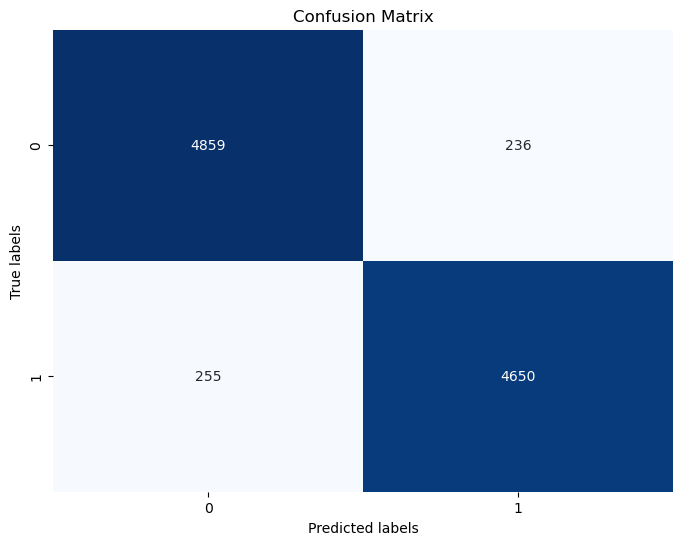

Train Loss: 0.007314 | Train Accuracy: 95.09% | Train F1-Score: 0.950879
Test Loss: 0.001987 | Test Accuracy: 99.55% | Test F1-Score: 0.995497


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [02:26<00:00,  4.27it/s, loss=0.0524]  


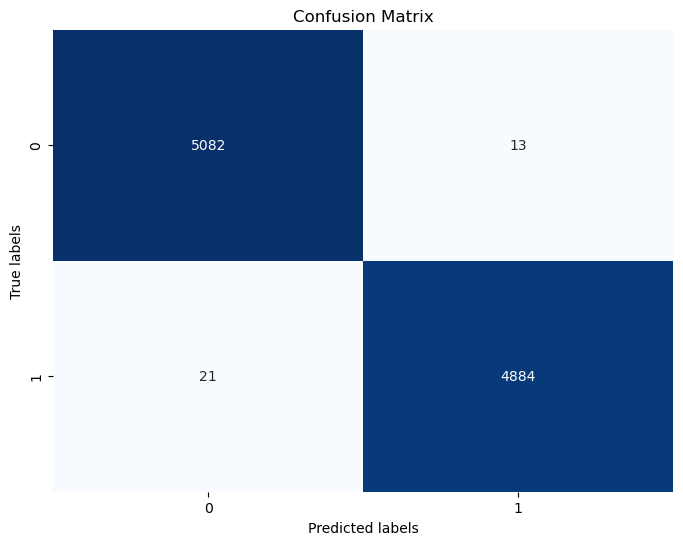

Train Loss: 0.000723 | Train Accuracy: 99.66% | Train F1-Score: 0.996599
Test Loss: 0.003146 | Test Accuracy: 99.15% | Test F1-Score: 0.991489


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [02:27<00:00,  4.25it/s, loss=0.00444] 


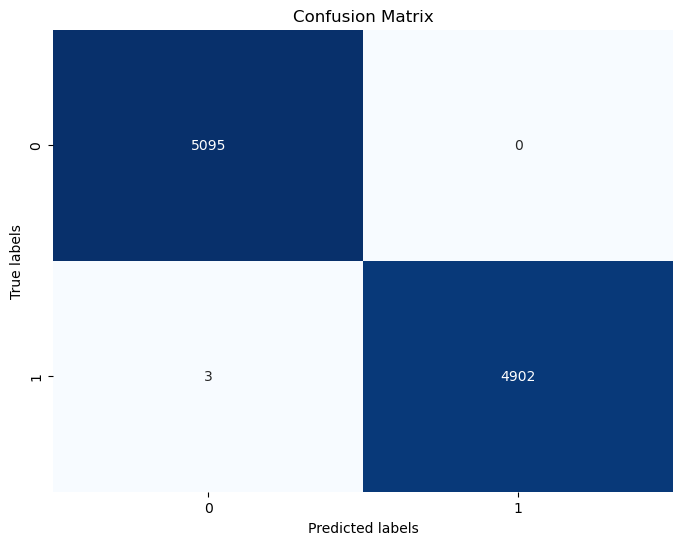

Train Loss: 0.000117 | Train Accuracy: 99.97% | Train F1-Score: 0.999700
Test Loss: 0.000549 | Test Accuracy: 99.85% | Test F1-Score: 0.998499


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [02:27<00:00,  4.23it/s, loss=0.000169]


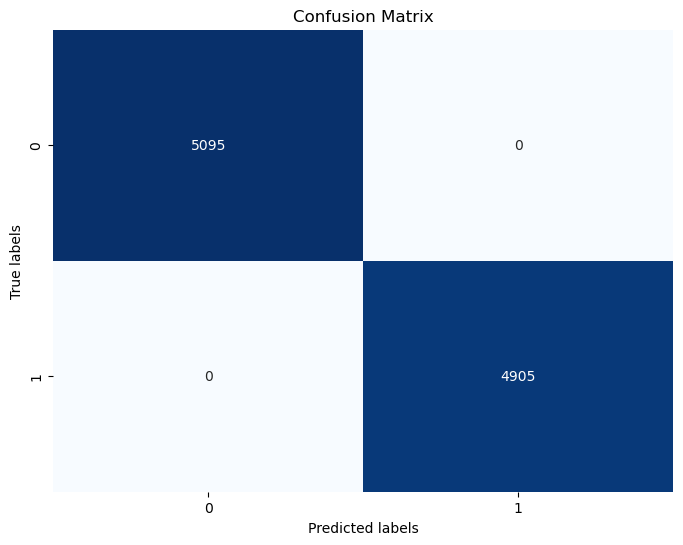

Train Loss: 0.000035 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000397 | Test Accuracy: 99.90% | Test F1-Score: 0.998999


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [02:26<00:00,  4.25it/s, loss=0.000368]


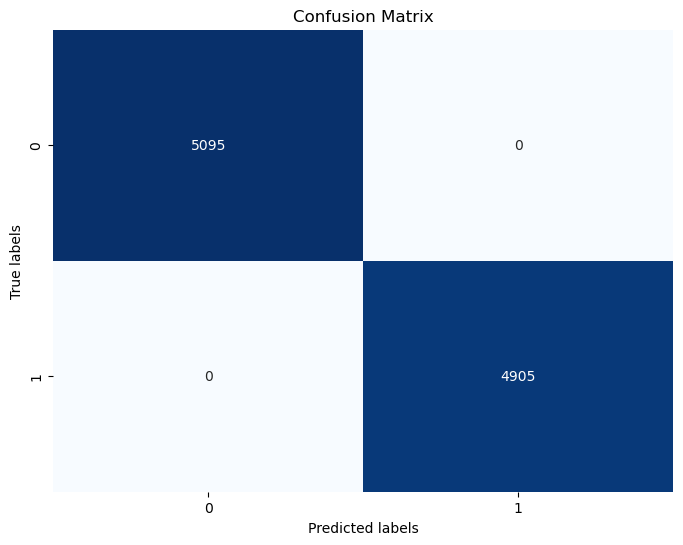

Train Loss: 0.000024 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000391 | Test Accuracy: 99.90% | Test F1-Score: 0.998999


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [02:27<00:00,  4.25it/s, loss=0.000142]


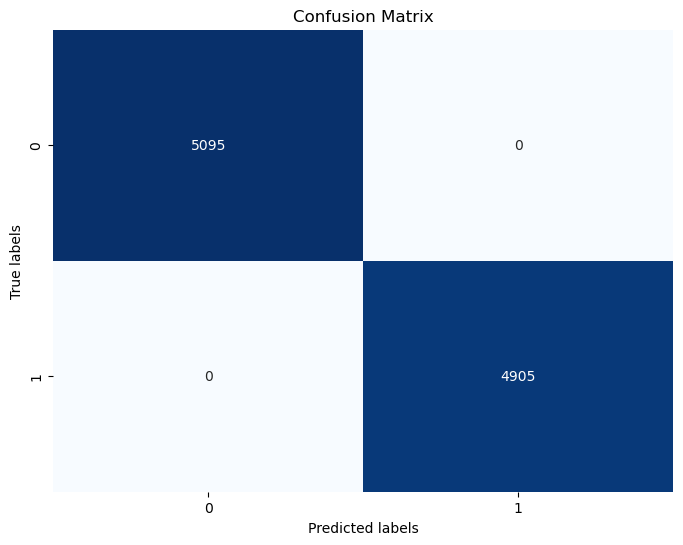

Train Loss: 0.000023 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000385 | Test Accuracy: 99.90% | Test F1-Score: 0.998999


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [02:26<00:00,  4.25it/s, loss=0.000634]


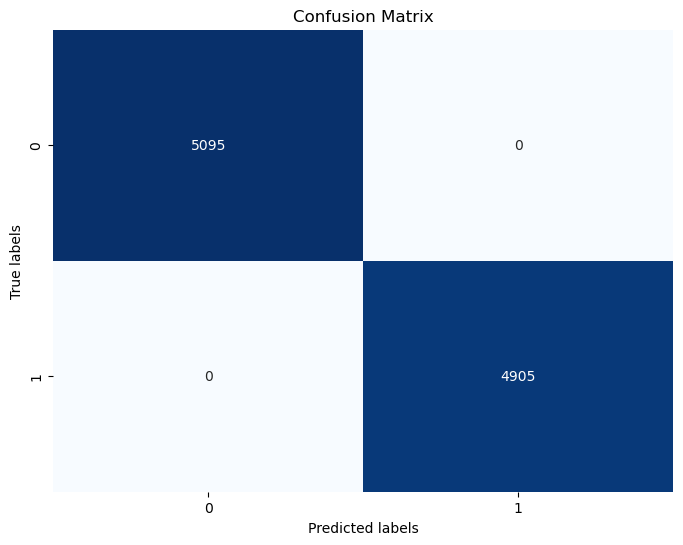

Train Loss: 0.000022 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000384 | Test Accuracy: 99.90% | Test F1-Score: 0.998999


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [02:27<00:00,  4.24it/s, loss=0.000167]


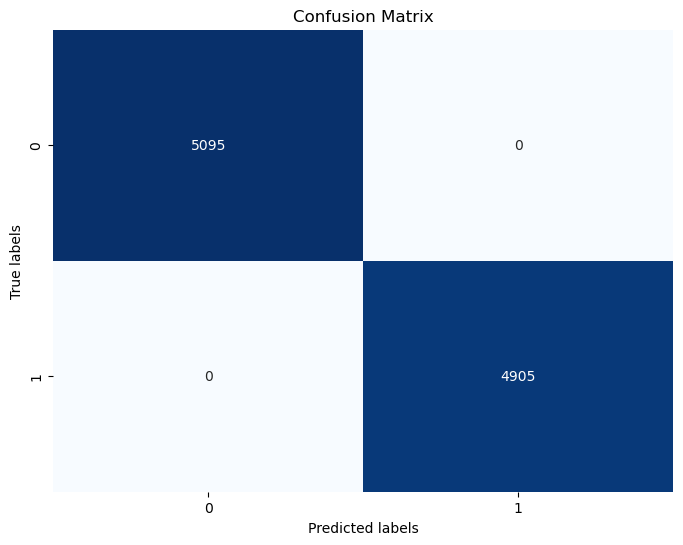

Train Loss: 0.000022 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000384 | Test Accuracy: 99.90% | Test F1-Score: 0.998999


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [02:26<00:00,  4.25it/s, loss=0.000277]


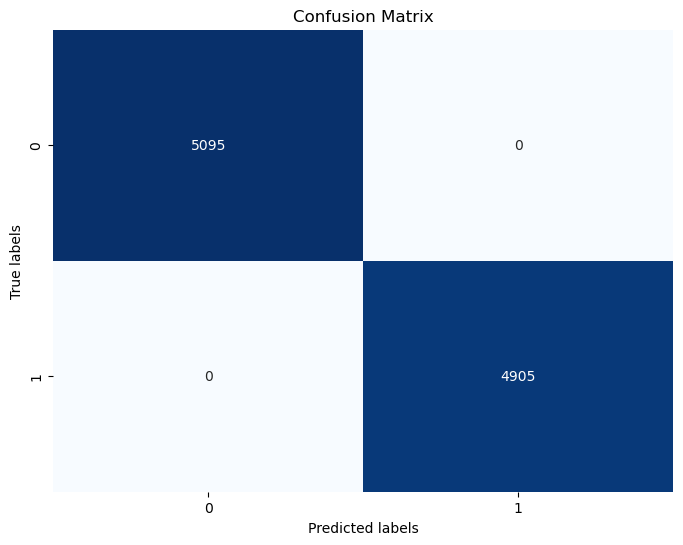

Train Loss: 0.000022 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000384 | Test Accuracy: 99.90% | Test F1-Score: 0.998999


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [02:27<00:00,  4.25it/s, loss=0.000219]


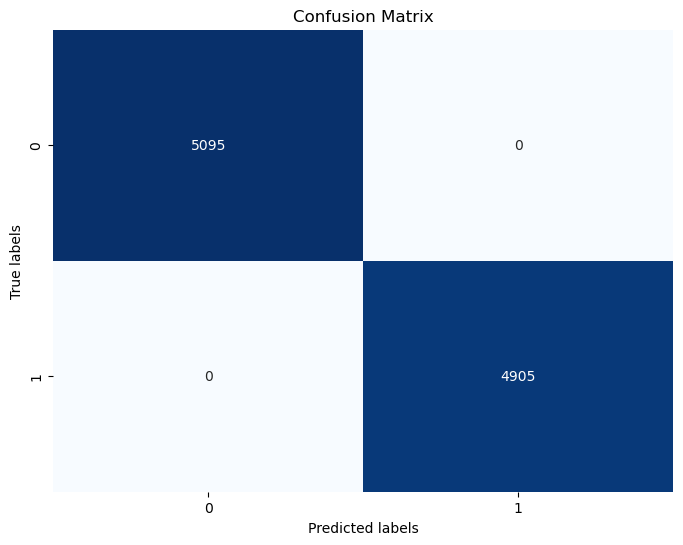

Train Loss: 0.000022 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000384 | Test Accuracy: 99.90% | Test F1-Score: 0.998999




In [41]:
running(0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)